In [1]:
import torch
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
class SimpleBPETokenizer:
    def __init__(self, num_merges=5, eot_token='<|endoftext|>'):
        self.num_merges = num_merges
        self.eot_token = eot_token
        self.eot_id = None
        self.merges = []
        self.pair_ranks = {}
        self.vocab = {}
        self.id_to_token = {}

    def _add_token(self, tok):
        if tok in self.vocab:
            return self.vocab[tok]
        i = len(self.vocab)
        self.vocab[tok] = i
        self.id_to_token[i] = tok
        return i

    def _get_bigrams(self, seq):
        for i in range(len(seq) - 1):
            yield (seq[i], seq[i + 1])

    def _merge_once(self, seq, pair):
        a, b = pair
        out = []
        i = 0
        while i < len(seq):
            if i < len(seq) - 1 and seq[i] == a and seq[i + 1] == b:
                out.append(a + b)
                i += 2
            else:
                out.append(seq[i])
                i += 1
        return out

    def train(self, corpus):
        # corpus: list[str]
        text = ''.join(corpus).lower()
        seq = list(text)
        merges = []
        for _ in range(self.num_merges):
            counts = Counter(self._get_bigrams(seq))
            if not counts: break
            best_pair, _ = counts.most_common(1)[0]
            merges.append(best_pair)
            seq = self._merge_once(seq, best_pair)
        self.merges = merges
        self.pair_ranks = {p: i for i, p in enumerate(self.merges)}

        self.vocab = {}
        self.id_to_token = {}
        for ch in sorted(set(text)):
            self._add_token(ch)
        for a, b in self.merges:
            self._add_token(a + b)
        self.eot_id = self._add_token(self.eot_token)

    def encode(self, text, force_last_eot=True):
        # treat literal eot marker as special; remove it from content
        if self.eot_token in text:
            text = text.replace(self.eot_token, '')
        seq = list(text)

        # make sure all seen base chars exist
        for ch in set(seq):
            if ch not in self.vocab:
                self._add_token(ch)

        # greedy BPE using learned pair ranks
        if self.merges:
            while True:
                best_pair, best_rank = None, None
                for p in self._get_bigrams(seq):
                    r = self.pair_ranks.get(p)
                    if r is not None and (best_rank is None or r < best_rank):
                        best_pair, best_rank = p, r
                if best_pair is None:
                    break
                seq = self._merge_once(seq, best_pair)

        # ensure all tokens in seq exist in vocab (e.g., if new chars appeared)
        for tok in seq:
            if tok not in self.vocab:
                self._add_token(tok)

        ids = [self.vocab[tok] for tok in seq]

        # FORCE: append EOT id if not already last
        if force_last_eot:
            if not ids or ids[-1] != self.eot_id:
                ids.append(self.eot_id)

        return ids

    def decode(self, ids):
        # drop trailing EOT if present
        if ids and self.eot_id is not None and ids[-1] == self.eot_id:
            ids = ids[:-1]
        toks = [self.id_to_token[i] for i in ids]
        return ''.join(toks)


In [3]:
twinkle_twinkle = r'CCGGAAG,FFEEDDC,GGFFEED,GGFFEED,CCGGAAG,FFEEDDC'
hot_cross_buns = r'EDC,EDC,CCCC,DDDD,EDC'
happy_birthday = r'GGAGCB,GGAGDC,GGGECBA,FFECDC'
mary_had_a_little_lamb = r'EDCDEEE,DDD,EGG,EDCDEEE,EDD,EDC'
frere_jacques = r'CDEC,CDEC,EFG,EFG,GAGFEC,GAGFEC,CGC,CGC'

In [4]:
tok = SimpleBPETokenizer(num_merges=6)
examples = [twinkle_twinkle,hot_cross_buns, happy_birthday, mary_had_a_little_lamb, frere_jacques]
tok.train(examples)
tok.merges

[('e', 'd'), ('c', ','), ('g', 'g'), ('f', 'e'), ('a', 'g'), ('c', 'c')]

In [5]:
tok.vocab

{',': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'ed': 8,
 'c,': 9,
 'gg': 10,
 'fe': 11,
 'ag': 12,
 'cc': 13,
 '<|endoftext|>': 14}

In [6]:
vocab_size = len(tok.vocab)
vocab_size

15

In [7]:
eot = tok.eot_id
tokens = []
for example in examples:
    tokens.extend([eot])
    tokens.extend(tok.encode(example.lower()))
all_tokens = torch.tensor(tokens, dtype=torch.long)
len_tok = len(all_tokens)
len_tok, all_tokens

(131,
 tensor([14, 13, 10,  1, 12,  0,  6, 11,  8,  4,  9, 10,  6, 11,  8,  0, 10,  6,
         11,  8,  0, 13, 10,  1, 12,  0,  6, 11,  8,  4,  3, 14, 14,  8,  9,  8,
          9, 13,  3,  9,  4,  4,  4,  4,  0,  8,  3, 14, 14, 10, 12,  3,  2,  0,
         10, 12,  4,  9, 10,  7,  5,  3,  2,  1,  0,  6, 11,  3,  4,  3, 14, 14,
          8,  3,  4,  5,  5,  5,  0,  4,  4,  4,  0,  5, 10,  0,  8,  3,  4,  5,
          5,  5,  0,  8,  4,  0,  8,  3, 14, 14,  3,  4,  5,  9,  3,  4,  5,  9,
          5,  6,  7,  0,  5,  6,  7,  0,  7, 12, 11,  9,  7, 12, 11,  9,  3,  7,
          9,  3,  7,  3, 14]))

## Training Code

In [8]:
class Conv2dExplicit(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=0, bias=False):
        super().__init__()
        kh, kw = kernel_size
        sh, sw = stride
        ph, pw = padding
        self.in_ch, self.out_ch = in_ch, out_ch
        self.kh, self.kw, self.sh, self.sw, self.ph, self.pw = kh, kw, sh, sw, ph, pw
        self.weight = nn.Parameter(torch.empty(out_ch, in_ch, kh, kw))
        self.bias = nn.Parameter(torch.zeros(out_ch)) if bias else None
        nn.init.kaiming_normal_(self.weight, mode="fan_out", nonlinearity="relu")
    def forward(self, x):
        N, C, H, W = x.shape
        cols = F.unfold(x, (self.kh, self.kw), padding=(self.ph, self.pw), stride=(self.sh, self.sw))
        Wflat = self.weight.view(self.out_ch, -1)
        out = Wflat @ cols
        if self.bias is not None: out = out + self.bias.view(1, -1, 1)
        Hout = (H + 2*self.ph - self.kh)//self.sh + 1
        Wout = (W + 2*self.pw - self.kw)//self.sw + 1
        return out.view(N, self.out_ch, Hout, Wout)

In [9]:
def conv1xk(in_ch, out_ch, k=3, stride_w=1, pad_w=None):
    if pad_w is None: pad_w = k//2
    return Conv2dExplicit(in_ch, out_ch, kernel_size=(1,k), stride=(1,stride_w), padding=(0,pad_w), bias=False)
    
class SingleConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = conv1xk(channels, channels, k=3, stride_w=1) # 1x3 stride 1
        self.bn_a = nn.BatchNorm2d(channels)
        self.conv2 = conv1xk(channels, channels, k=3, stride_w=2) # 1x3 stride 2
        self.bn_b = nn.BatchNorm2d(channels)
        self.convRes = conv1xk(channels, channels, k=1, stride_w=2, pad_w=0) #1x1 stride 2
        # c and g are ReLU and residual connection inside forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn_a(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn_b(out)
        identity = self.convRes(x)
        out = out + identity
        return out

In [10]:
class TinyTextCNN(nn.Module):
    def __init__(self, vocab_size, n_embd=6):
        super().__init__()
        self.vocab_size, self.n_embd = vocab_size, n_embd
        self.wte = nn.Embedding(vocab_size, n_embd)
        self.block = SingleConvBlock(n_embd)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        nn.init.normal_(self.lm_head.weight, 0, 0.02)
    def forward(self, X, Y=None):
        B, T = X.shape
        x = self.wte(X)
        x = x.permute(0,2,1).unsqueeze(2)
        x = self.block(x)
        x = self.avgPool(x)
        x = x.squeeze(2).permute(0,2,1)
        logits = self.lm_head(x)
        loss = None
        if Y is not None:
            T_out = logits.size(1)
            Y = Y[:, :T_out]
            loss = F.cross_entropy(logits.reshape(B*T_out, self.vocab_size), Y.reshape(B*T_out))
        return logits, loss

In [11]:
def get_batch(all_tokens, cur_position, b, t, len_tok=len_tok):
        
    window = b * t + 1
    cur_position += random.randint(1, t) 
    if cur_position >= len_tok:
        cur_position -= len_tok
    end = cur_position + window
    if end <= len_tok:
        tok_for_training = all_tokens[cur_position:end]
    else:
        restart = end-len_tok
        tok_for_training = torch.cat((all_tokens[cur_position:],all_tokens[:restart]), dim=0)
        position = end % len_tok

    x = tok_for_training[:-1].view(b, t)
    y = tok_for_training[t::t].view(b, 1)

    return  x, y, cur_position

In [12]:
torch.manual_seed(0)
B_batch, T_context, n_embd = 2, 8, 6
cur_position = 0
learning_rate = 1e-4
training_steps = 100000

In [13]:
model = TinyTextCNN(vocab_size=vocab_size, n_embd=n_embd)
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [14]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total, trainable)

456 456


In [15]:
model.train()

max_lr= 1e-2
scheduler = OneCycleLR(
    opt, max_lr=max_lr, total_steps=training_steps,
    pct_start=0.1, anneal_strategy='cos', cycle_momentum=False
)
lossi = []

In [16]:
for step in range(training_steps):
    x, y, cur_position = get_batch(all_tokens, cur_position, B_batch, T_context, len_tok)
    logits, loss = model(x, y)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    scheduler.step()
    lossi.append(loss.item())
    if step % 1000 == 0:
        print(f'step {step} loss {loss.item():.4f}')

step 0 loss 2.7314
step 1000 loss 2.3915
step 2000 loss 1.7371
step 3000 loss 0.5785
step 4000 loss 1.6708
step 5000 loss 2.0368
step 6000 loss 1.6624
step 7000 loss 0.9160
step 8000 loss 2.3188
step 9000 loss 0.5319
step 10000 loss 0.2991
step 11000 loss 0.9256
step 12000 loss 0.2787
step 13000 loss 0.1429
step 14000 loss 0.5148
step 15000 loss 0.3242
step 16000 loss 0.1570
step 17000 loss 1.6638
step 18000 loss 0.0027
step 19000 loss 0.7556
step 20000 loss 0.2918
step 21000 loss 0.1316
step 22000 loss 0.4115
step 23000 loss 0.2037
step 24000 loss 0.1675
step 25000 loss 0.1974
step 26000 loss 0.0472
step 27000 loss 0.0260
step 28000 loss 0.2235
step 29000 loss 0.2035
step 30000 loss 0.1105
step 31000 loss 0.4434
step 32000 loss 0.4879
step 33000 loss 0.2683
step 34000 loss 0.3531
step 35000 loss 0.1668
step 36000 loss 0.2157
step 37000 loss 0.4550
step 38000 loss 0.0481
step 39000 loss 0.3595
step 40000 loss 0.1199
step 41000 loss 0.0751
step 42000 loss 0.2390
step 43000 loss 0.2263
s

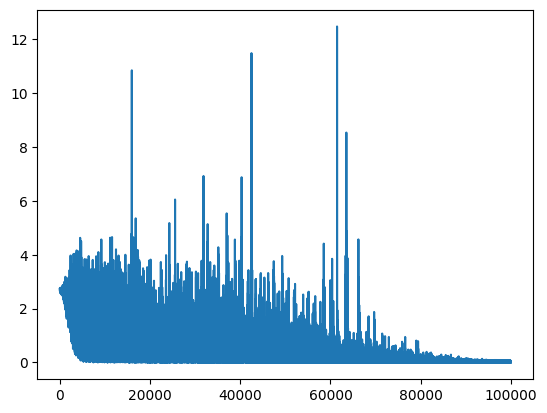

In [17]:
plt.plot(lossi)

## Forward Pass

In [60]:
current_position = 0
tok_for_training = all_tokens[current_position:current_position + B_batch*T_context +1 ]
tok_for_training

tensor([14, 13, 10,  1, 12,  0,  6, 11,  8,  4,  9, 10,  6, 11,  8,  0, 10])

In [89]:
x=tok_for_training[:-1].view(B_batch, T_context)
x.size(), x

(torch.Size([2, 8]),
 tensor([[14, 13, 10,  1, 12,  0,  6, 11],
         [ 8,  4,  9, 10,  6, 11,  8,  0]]))

In [90]:
y=tok_for_training[T_context::T_context].view(B_batch, 1)
y.size(), y

(torch.Size([2, 1]),
 tensor([[ 8],
         [10]]))

#### Input Layer - Embedding Projection


In [91]:
x = model.wte(x)
x.shape, x

(torch.Size([2, 8, 6]),
 tensor([[[-0.3538, -1.7279, -0.2208, -0.1422, -0.2779,  0.0971],
          [ 0.1340, -1.9109,  0.8488,  0.3037,  0.5439,  1.2975],
          [-0.1212, -1.0493,  1.3160, -0.6819, -0.1818,  0.3020],
          [ 0.9336,  0.3767, -1.2423, -0.2280, -0.2998,  0.3576],
          [-0.8815,  0.6066, -0.0922,  1.2983,  1.0177,  0.3613],
          [-1.1437, -0.3150, -1.0516, -0.0303, -0.0545,  0.2966],
          [-0.2197, -0.6855,  0.0498, -0.2830,  2.2638, -0.2275],
          [ 0.6324,  0.3081, -0.6845, -0.1421,  1.0040, -0.5515]],
 
         [[ 0.0611,  0.7857,  0.4427,  0.1858, -0.2440,  1.0037],
          [ 0.2021,  0.2374,  0.0892, -1.0603, -0.0903,  0.5618],
          [ 0.0355,  0.6805, -0.4257,  0.7430,  0.8040,  1.0051],
          [-0.1212, -1.0493,  1.3160, -0.6819, -0.1818,  0.3020],
          [-0.2197, -0.6855,  0.0498, -0.2830,  2.2638, -0.2275],
          [ 0.6324,  0.3081, -0.6845, -0.1421,  1.0040, -0.5515],
          [ 0.0611,  0.7857,  0.4427,  0.1858, -0

#### Input Layer - Add Dimension


In [92]:
x = x.permute(0,2,1).unsqueeze(2)
x.size(), x

(torch.Size([2, 6, 1, 8]),
 tensor([[[[-0.3538,  0.1340, -0.1212,  0.9336, -0.8815, -1.1437, -0.2197,
             0.6324]],
 
          [[-1.7279, -1.9109, -1.0493,  0.3767,  0.6066, -0.3150, -0.6855,
             0.3081]],
 
          [[-0.2208,  0.8488,  1.3160, -1.2423, -0.0922, -1.0516,  0.0498,
            -0.6845]],
 
          [[-0.1422,  0.3037, -0.6819, -0.2280,  1.2983, -0.0303, -0.2830,
            -0.1421]],
 
          [[-0.2779,  0.5439, -0.1818, -0.2998,  1.0177, -0.0545,  2.2638,
             1.0040]],
 
          [[ 0.0971,  1.2975,  0.3020,  0.3576,  0.3613,  0.2966, -0.2275,
            -0.5515]]],
 
 
         [[[ 0.0611,  0.2021,  0.0355, -0.1212, -0.2197,  0.6324,  0.0611,
            -1.1437]],
 
          [[ 0.7857,  0.2374,  0.6805, -1.0493, -0.6855,  0.3081,  0.7857,
            -0.3150]],
 
          [[ 0.4427,  0.0892, -0.4257,  1.3160,  0.0498, -0.6845,  0.4427,
            -1.0516]],
 
          [[ 0.1858, -1.0603,  0.7430, -0.6819, -0.2830, -0.1421,  0.1

### Convolution Block

In [93]:
out = model.block.conv1(x)
out

tensor([[[[-1.5438, -1.8343,  0.7778,  1.1903,  0.6596, -0.4334, -0.2239,
            1.3149]],

         [[ 1.3532,  0.0383, -2.2688,  2.1619, -0.0755,  0.2142, -1.4898,
           -1.4063]],

         [[ 2.6253,  2.1959,  1.5959, -1.4981, -1.4970,  0.5298, -1.6367,
           -0.1397]],

         [[-1.7402,  0.4375,  1.8362, -0.4476, -0.0293, -1.0450, -0.1744,
            0.0190]],

         [[ 1.3656,  0.5332, -2.7385, -1.5942,  1.3431,  1.1098, -1.0376,
            0.2761]],

         [[-1.5111, -1.7708, -0.6487,  1.7748,  0.3640,  1.7602, -0.3405,
           -0.5390]]],


        [[[-0.9065, -0.3760,  0.0365, -1.6030,  1.2263,  1.1063, -1.2582,
            1.4567]],

         [[-0.1590,  0.1067,  0.1788, -1.5672,  0.0867, -0.8862, -0.4605,
            0.5962]],

         [[ 0.4418,  0.2572,  0.7289,  2.2856, -0.2720,  0.2183, -0.3050,
            0.0085]],

         [[ 0.6363, -0.7065, -0.8836, -0.0517,  0.5558,  0.1195,  0.7595,
           -1.0517]],

         [[-0.3509, -0.9530,

In [94]:
out = model.block.bn_a(out)
out

tensor([[[[-0.8087, -0.9507,  0.3257,  0.5273,  0.2680, -0.2662, -0.1638,
            0.5882]],

         [[ 0.5618,  0.0563, -0.8307,  0.8728,  0.0125,  0.1239, -0.5312,
           -0.4991]],

         [[ 0.5243,  0.3487,  0.1034, -1.1616, -1.1611, -0.3325, -1.2183,
           -0.6062]],

         [[-0.7522,  0.4143,  1.1635, -0.0598,  0.1643, -0.3798,  0.0865,
            0.1902]],

         [[ 0.4589,  0.1833, -0.9000, -0.5211,  0.4515,  0.3743, -0.3368,
            0.0982]],

         [[-1.3687, -1.5202, -0.8655,  0.5485, -0.2746,  0.5400, -0.6857,
           -0.8015]]],


        [[[-0.4973, -0.2381, -0.0365, -0.8377,  0.5449,  0.4862, -0.6692,
            0.6575]],

         [[-0.0196,  0.0826,  0.1103, -0.5610,  0.0749, -0.2992, -0.1355,
            0.2708]],

         [[-0.3684, -0.4439, -0.2511,  0.3854, -0.6603, -0.4598, -0.6738,
           -0.5456]],

         [[ 0.5208, -0.1985, -0.2933,  0.1523,  0.4777,  0.2440,  0.5868,
           -0.3833]],

         [[-0.1094, -0.3088,

In [95]:
out = F.relu(out)
out

tensor([[[[0.0000, 0.0000, 0.3257, 0.5273, 0.2680, 0.0000, 0.0000, 0.5882]],

         [[0.5618, 0.0563, 0.0000, 0.8728, 0.0125, 0.1239, 0.0000, 0.0000]],

         [[0.5243, 0.3487, 0.1034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.4143, 1.1635, 0.0000, 0.1643, 0.0000, 0.0865, 0.1902]],

         [[0.4589, 0.1833, 0.0000, 0.0000, 0.4515, 0.3743, 0.0000, 0.0982]],

         [[0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.5400, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000, 0.5449, 0.4862, 0.0000, 0.6575]],

         [[0.0000, 0.0826, 0.1103, 0.0000, 0.0749, 0.0000, 0.0000, 0.2708]],

         [[0.0000, 0.0000, 0.0000, 0.3854, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.5208, 0.0000, 0.0000, 0.1523, 0.4777, 0.2440, 0.5868, 0.0000]],

         [[0.0000, 0.0000, 0.1527, 0.3704, 0.0000, 0.2429, 0.3659, 0.1316]],

         [[0.1229, 0.1800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]],
       grad_fn=<ReluBackward0>)

In [96]:
out = model.block.conv2(out)
out

tensor([[[[-0.0205, -0.0948,  0.6327, -0.3263]],

         [[-0.1981, -0.5394, -0.2201, -0.1169]],

         [[-0.1069, -0.3643,  0.4101,  0.1075]],

         [[ 0.0188, -0.0428, -0.8928,  0.4109]],

         [[-0.4434, -0.5494, -0.0349, -0.2168]],

         [[-0.3652, -0.2399,  0.2695,  0.6908]]],


        [[[ 0.1212,  0.0863, -0.2642, -0.2323]],

         [[-0.2575,  0.1796, -0.0595, -0.2123]],

         [[-0.0642,  0.1111,  0.2721, -0.4824]],

         [[-0.1205,  0.0011, -0.1129,  0.3895]],

         [[-0.3531, -0.4930, -0.2933, -0.3222]],

         [[-0.1048, -0.0677,  0.4173,  0.0026]]]], grad_fn=<ViewBackward0>)

In [97]:
out = model.block.bn_b(out)
out

tensor([[[[  0.2974,  -1.7095,  17.9336,  -7.9594]],

         [[ -0.6157, -15.3298,  -1.5639,   2.8861]],

         [[ -0.2852,  -4.2287,   7.6366,   3.0005]],

         [[  1.2572,   0.2816, -13.1710,   7.4617]],

         [[ -5.5067, -10.3068,  12.9883,   4.7507]],

         [[ -6.8455,  -4.6658,   4.1988,  11.5314]]],


        [[[  4.1219,   3.1811,  -6.2829,  -5.4211]],

         [[ -3.1777,  15.6672,   5.3587,  -1.2289]],

         [[  0.3699,   3.0556,   5.5218,  -6.0378]],

         [[ -0.9472,   0.9759,  -0.8272,   7.1241]],

         [[ -1.4197,  -7.7539,   1.2889,  -0.0189]],

         [[ -2.3136,  -1.6697,   6.7717,  -0.4448]]]],
       grad_fn=<NativeBatchNormBackward0>)

### Residual Connection

In [98]:
identity = model.block.convRes(x)
identity

tensor([[[[-6.9052, -5.4700,  0.6940, -4.3136]],

         [[-1.4775,  2.0132, -4.6039, -0.8955]],

         [[ 2.6279,  1.2826,  2.6689,  7.6903]],

         [[-1.3493, -3.0138,  4.9637, -1.9745]],

         [[-6.8618, -5.9337,  7.2757,  1.2419]],

         [[-0.2063, -2.0876, -1.7645, -6.8481]]],


        [[[ 3.7676,  4.1082, -4.3136,  3.7676]],

         [[-0.2943, -3.4238, -0.8955, -0.2943]],

         [[-1.5818,  1.6430,  7.6903, -1.5818]],

         [[-0.1494,  0.7467, -1.9745, -0.1494]],

         [[ 3.2147,  5.9827,  1.2419,  3.2147]],

         [[ 1.9591,  0.4460, -6.8481,  1.9591]]]], grad_fn=<ViewBackward0>)

In [99]:
x = out + identity
x

tensor([[[[ -6.6077,  -7.1795,  18.6277, -12.2730]],

         [[ -2.0932, -13.3166,  -6.1678,   1.9906]],

         [[  2.3427,  -2.9461,  10.3055,  10.6908]],

         [[ -0.0921,  -2.7322,  -8.2073,   5.4871]],

         [[-12.3685, -16.2405,  20.2640,   5.9927]],

         [[ -7.0518,  -6.7534,   2.4343,   4.6834]]],


        [[[  7.8895,   7.2893, -10.5965,  -1.6535]],

         [[ -3.4721,  12.2435,   4.4632,  -1.5233]],

         [[ -1.2120,   4.6986,  13.2120,  -7.6196]],

         [[ -1.0966,   1.7225,  -2.8017,   6.9748]],

         [[  1.7951,  -1.7712,   2.5308,   3.1959]],

         [[ -0.3545,  -1.2236,  -0.0763,   1.5143]]]], grad_fn=<AddBackward0>)

#### Output Layers

In [100]:
x = model.avgPool(x)
x

tensor([[[[-1.8581]],

         [[-4.8968]],

         [[ 5.0982]],

         [[-1.3861]],

         [[-0.5881]],

         [[-1.6719]]],


        [[[ 0.7322]],

         [[ 2.9278]],

         [[ 2.2698]],

         [[ 1.1997]],

         [[ 1.4376]],

         [[-0.0350]]]], grad_fn=<MeanBackward1>)

In [101]:
x = x.squeeze(2).permute(0,2,1)
x

tensor([[[-1.8581, -4.8968,  5.0982, -1.3861, -0.5881, -1.6719]],

        [[ 0.7322,  2.9278,  2.2698,  1.1997,  1.4376, -0.0350]]],
       grad_fn=<PermuteBackward0>)

In [102]:
logits = model.lm_head(x)
logits

tensor([[[ -6.4625,   6.4465,   3.7128,   7.7496,   3.9683, -32.9022,   4.0918,
          -23.3142,  15.8635,  11.2772, -12.5994, -20.7938,   5.8372,   4.9852,
          -30.2750]],

        [[  2.9112,   3.1109, -12.4211,   4.5833,  -3.0127,  -6.8175,   5.3184,
          -11.4279,  -0.9332,  -7.2218,  12.1359,   4.1800,  -2.6490,  -1.1821,
            5.7186]]], grad_fn=<UnsafeViewBackward0>)

### Updated Loss calculation

In [103]:
y_flat = y.view(-1)
logits_flat = logits.view(-1, logits.size(-1))
loss = F.cross_entropy(logits_flat, y_flat)
print(loss.shape, loss)

torch.Size([]) tensor(0.0072, grad_fn=<NllLossBackward0>)


### Next Token Prediction from Logits

In [154]:
tok_for_training = all_tokens[current_position:current_position + B_batch*T_context +1 ]
xgen =tok_for_training[:-1].view(B_batch, T_context)
max_length = 16
num_return_sequences = 2

In [155]:
while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits, loss = model(xgen[:,-B_batch:]) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # select a token 
        xcol = torch.multinomial(probs, 1, generator=sample_rng) # (B, 1)
        # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)


In [156]:
xgen

tensor([[14, 13, 10,  1, 12,  0,  6, 11, 12,  0, 13,  2,  8, 14, 14,  2],
        [ 8,  4,  9, 10,  6, 11,  8,  0,  5,  2,  4,  5, 10,  0,  1,  4]])

In [157]:
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = tok.decode(tokens)
    print(f'sample {i}: {decoded}')

sample 0: <|endoftext|>ccggaag,ffeag,ccbed<|endoftext|><|endoftext|>b
sample 1: eddc,ggffeed,ebdegg,ad


In [164]:
tokens_original = tok_for_training[:].tolist()
tokens_original, tok.decode(tokens_original)

([14, 13, 10, 1, 12, 0, 6, 11, 8, 4, 9, 10, 6, 11, 8, 0, 10],
 '<|endoftext|>ccggaag,ffeeddc,ggffeed,gg')